In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,2.5)
plt.rcParams["figure.dpi"] = 300

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,DeprecationWarning))

In [6]:
# simulate one half-period of an underwater pendulum
@np.vectorize
def simulate(sg,l,g,theta0,d,rho,mu):
    theta, dot_theta, t, dt = abs(theta0), -1e-4, 0, 1e-3*2*np.pi*np.sqrt(l/g)
    A,V = np.pi/4*d**2,0.524*d**3
    T,I = (sg-1)*rho*V*g*l,(sg+0.5)*rho*V*l**2+sg*rho*V*d**2/10
    def cd(Re): return max(24./Re, 0.5 if Re<1e5 else 0.25)
    def b(u): return 0.5*rho*A*cd(rho*u*l/mu)*u*l
    while dot_theta <= -1e-4:           # stop when pendulum reverses
        u = max(-dot_theta*l,1e-3)
        ddot_theta = (-b(u)*dot_theta-T*np.sin(theta))/I
        t += dt                             # update time
        theta += dt*dot_theta               # update angle
        dot_theta += dt*ddot_theta          # update velocity
    return np.pi/t                  # return frequency

# set up N experiments
N = 1000; np.random.seed(100)
sg = 2.7+(19.3-2.7)*np.random.random(N) # aluminum to gold
l = 0.5+np.random.random(N)             # 50..150 cm rod
planets = [3.61,8.83,9.81,3.75,26.0,11.2,10.5,13.3]
g = np.random.choice(planets,N)         # pick a planet
theta0 = np.pi*(np.random.random(N)-0.5) # -2..2 radians
d = 0.005+0.045*np.random.random(N)      # 5..25 mm ball
f = np.random.random(N)                 # water/glycerol fraction
rho,mu = 1000+265*f,0.001+3*f
mass = 0.524*sg*rho*d**3

# run
omega = simulate(sg,l,g,theta0,d,rho,mu)

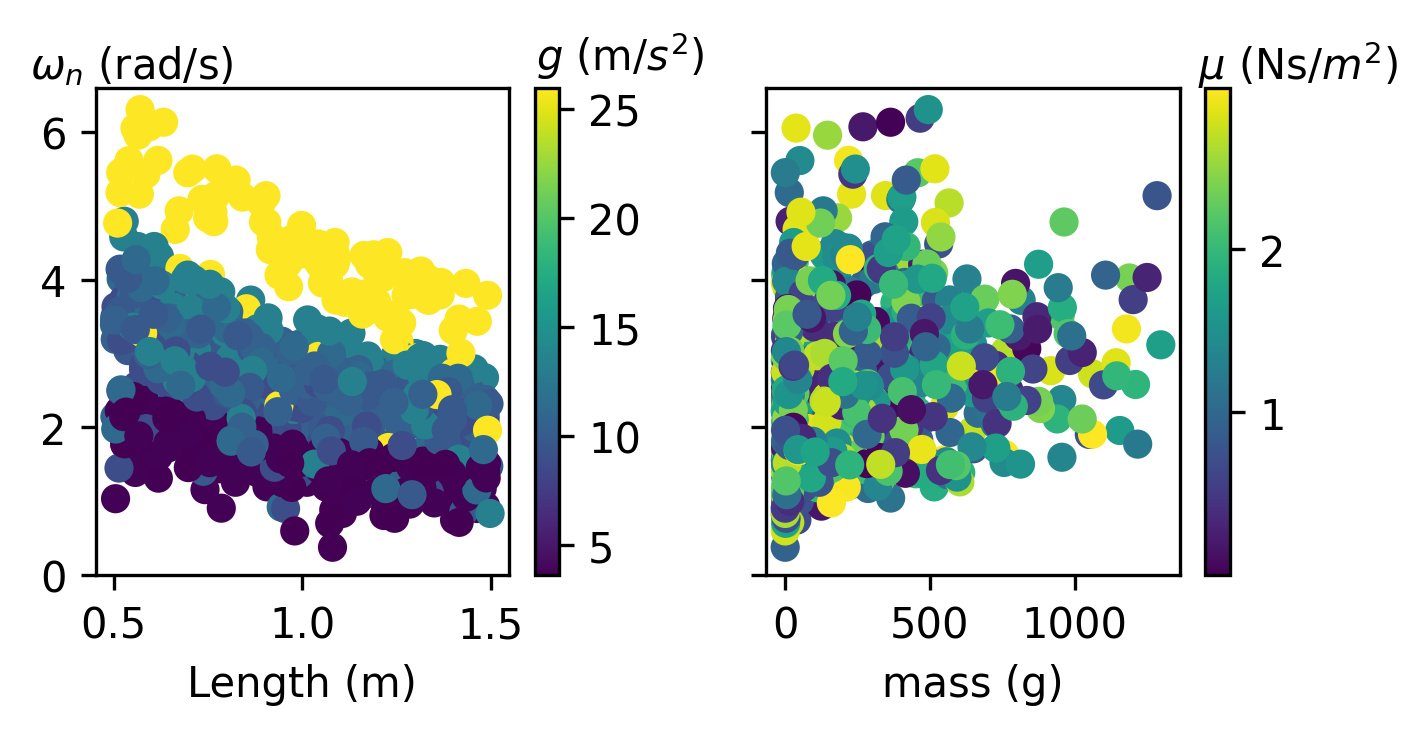

In [20]:
fig, ax = plt.subplots(1,2,sharey=True)
scatter0 = ax[0].scatter(l,omega,c=g)
fig.colorbar(scatter0, ax=ax[0]).set_label('$g$ (m/$s^2$)',rotation=0,y=1.12,labelpad=-5)
ax[0].set_ylabel(r'$\omega_n$ (rad/s)',rotation=0,labelpad=-22,y=1); ax[0].set_ylim(0,)
ax[0].set_xlabel('Length (m)')

scatter1 = ax[1].scatter(1000*mass,omega,c=mu)
fig.colorbar(scatter1, ax=ax[1]).set_label('$\mu$ (Ns/$m^2$)',rotation=0,y=1.1,labelpad=3)
ax[1].set_xlabel("mass (g)")
plt.tight_layout()
plt.savefig('pendulum_bad_scaling.png')

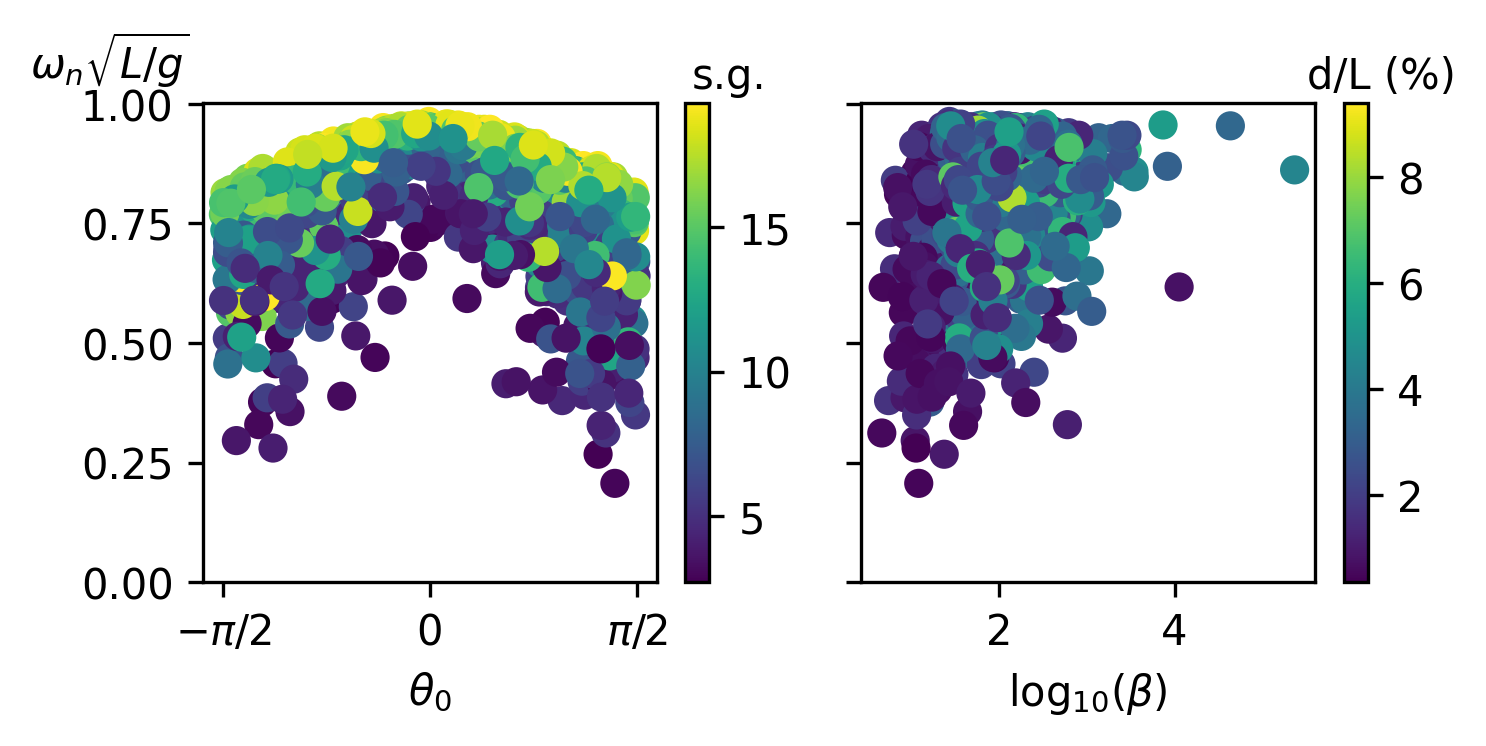

In [38]:
fig, ax = plt.subplots(1,2,sharey=True)
scatter0 = ax[0].scatter(theta0,omega*np.sqrt(l/g),c=sg)
fig.colorbar(scatter0, ax=ax[0]).set_label('s.g.',rotation=0,y=1.1,labelpad=-15)
ax[0].set_ylabel(r'$\omega_n \sqrt{L/g}$',rotation=0, y=1.03, labelpad=-7); ax[0].set_ylim(0,)
ax[0].set_xlabel(r'$\theta_0$'); ax[0].set_xticks([-3.14/2,0,3.14/2]); ax[0].set_xticklabels(['$-\pi/2$',0,'$\pi/2$'])

beta = np.log10(rho*d*np.sqrt(l*g)/mu)
scatter1 = ax[1].scatter(beta,omega*np.sqrt(l/g),c=100*d/l)
fig.colorbar(scatter1, ax=ax[1]).set_label('d/L (%)',rotation=0,y=1.1,labelpad=-10)
ax[1].set_xlabel(r'$\log_{10}(\beta)$')
plt.tight_layout()
plt.savefig('pendulum_better_scaling.png')

In [11]:
## Define models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import RegressorMixin,clone

class feature_map(RegressorMixin):
    def __init__(self,model=LinearRegression(),phi=lambda X:X,psi=lambda X,y:y,apsi=lambda X,y:y):
        self.model,self.phi,self.psi,self.apsi = model,phi,psi,apsi
        
    def fit(self, X=None, y=None):
        self.model.fit(self.phi(X),self.psi(X,y))

    def predict(self, X=None):
        return self.apsi(X,self.model.predict(self.phi(X)))

# Linear model
linear_model = make_pipeline(PolynomialFeatures(),LinearRegression())

# Bayesian Ridge model
regularized_model = make_pipeline(PolynomialFeatures(3),BayesianRidge())

# Buckingham Pi mapping
def phi(X): 
    return pd.DataFrame({'theta0':X.theta0,'sg':X.mass/(X.rho*X.d**3)})
def psi(X,y): return y*np.sqrt(X.l/X.g)
def apsi(X,y): return y/np.sqrt(X.l/X.g)

# Phi-feature model
phi_model = feature_map(clone(linear_model),phi,psi,apsi)

In [ ]:
# Define data set
X = pd.DataFrame({x:eval(x) for x in ['theta0','mass','l','g','d','rho','mu']})
y = omega

# split -> fit -> test
from sklearn.model_selection import train_test_split
def subfit(n,model,state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=state)
    model.fit(X_train, y_train)
    return {'score':model.score(X_test,y_test),'n':n,'state':state}

# loop through the data set sizes
def evaluate(model):
    return pd.DataFrame([subfit(n,model,state)
                         for n in np.logspace(1,2.8,20).astype(int)
                         for state in range(20)])

# evaluate models
linear_results = evaluate(linear_model)
regularized_results = evaluate(regularized_model)
phi_results = evaluate(phi_model)

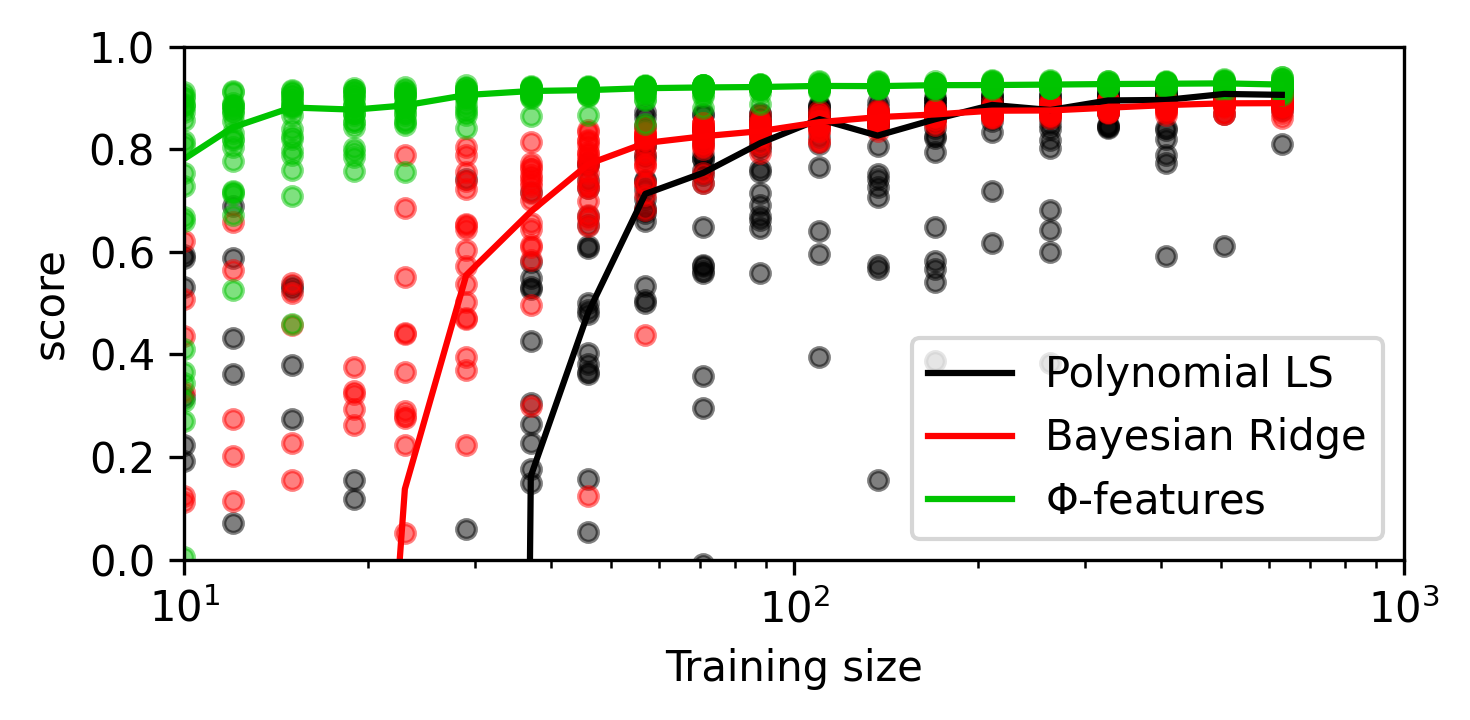

In [51]:
fig,ax = plt.subplots()
linear_results.plot.scatter(x='n',y='score',ax=ax,c='k',alpha=0.5)
linear_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,c='k',label='Polynomial LS')
plt.ylim(0,1)
plt.xscale('log'); plt.xlim(10,1e3)
plt.legend()
plt.xlabel('Training size N')
plt.tight_layout()
plt.savefig('pendulum_LS.png')

regularized_results.plot.scatter(x='n',y='score',ax=ax,c='r',alpha=0.5)
regularized_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,c='r',label='Bayesian Ridge')
plt.xlabel('Training size')
plt.savefig('pendulum_regularized.png')

green = '#00c400'
phi_results.plot.scatter(x='n',y='score',ax=ax,c=green,alpha=0.5)
phi_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,c=green,label='$\Phi$-features')
plt.xlabel('Training size')
plt.savefig('pendulum_Pi.png')

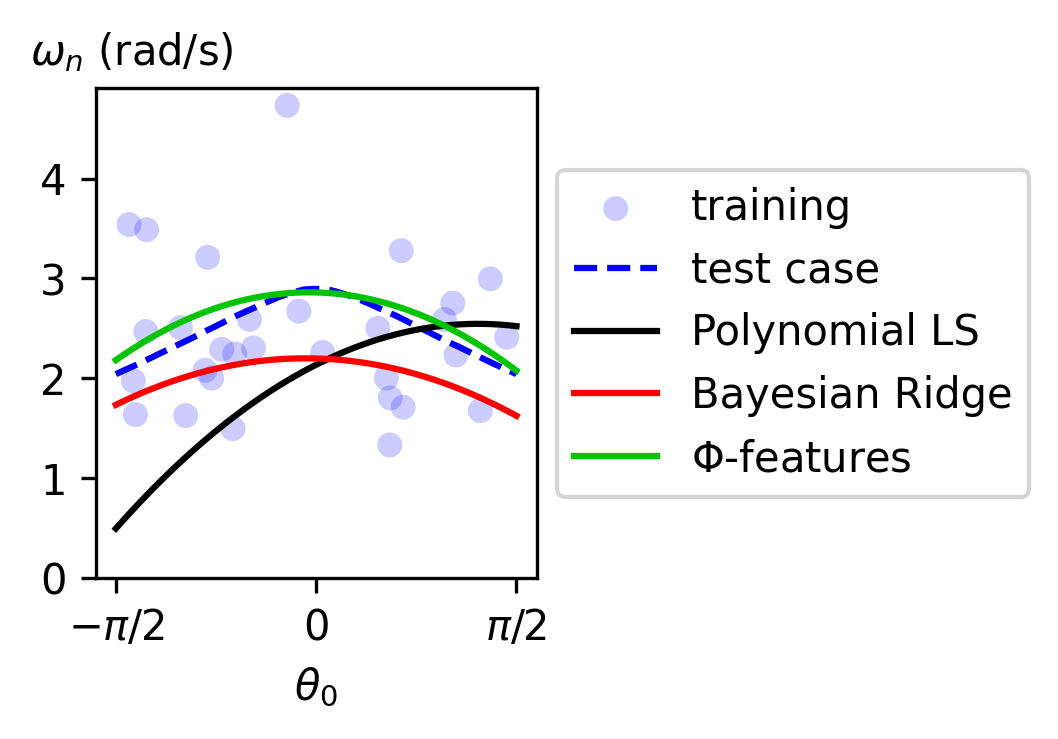

In [78]:
# Train an example model of each type
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=30, random_state=25) #15
linear_model.fit(X_train,y_train)
regularized_model.fit(X_train,y_train)
phi_model.fit(X_train,y_train)

# Test on _one_ pendulum
sg_test,d_test = 10,0.01
X_test = pd.DataFrame({'theta0':np.linspace(-np.pi/2,np.pi/2),'mass':524*sg_test*d_test**3,
                       'l':1.,'g':9.81,'d':d_test,'rho':1000,'mu':0.001})
y_test = simulate(np.ones_like(X_test.g)*sg_test,X_test.l,X_test.g,X_test.theta0,X_test.d,X_test.rho,X_test.mu)

# Plot
fig,ax = plt.subplots(figsize=(3.5,2.5))
ax.scatter(X_train.theta0,y_train,c='b',edgecolor='none',alpha=0.2,label='training')
ax.set_xlabel(r'$\theta_0$'); ax.set_xticks([-3.14/2,0,3.14/2]); ax.set_xticklabels(['$-\pi/2$',0,'$\pi/2$'])
ax.set_ylabel(r'$\omega_n$ (rad/s)',rotation=0, y=1.03, labelpad=-22); ax.set_ylim(0,)
plt.tight_layout()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

ax.plot(X_test.theta0,y_test,c='b',ls='--',label='test case')
ax.plot(X_test.theta0,linear_model.predict(X_test),c='k',label='Polynomial LS')
ax.plot(X_test.theta0,regularized_model.predict(X_test),c='r',label='Bayesian Ridge')
ax.plot(X_test.theta0,phi_model.predict(X_test),c=green,label='$\Phi$-features')
ax.legend(*([ x[i] for i in [-1,0,1,2,3] ] for x in plt.gca().get_legend_handles_labels()),
          loc='center left', bbox_to_anchor=(1,0.5),)
plt.savefig('pendulum_compare.png')